<a href="https://colab.research.google.com/github/yukinaga/object_detection/blob/main/section_1/01_pytorch_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNの実装
PyTorchを使って、畳み込みニューラルネットワーク（CNN）を実装します。  
CNN自体はCNNの層を追加するのみで実装可能なのですが、今回はデータ拡張とドロップアウトの実装も行います。


## CIFAR-10
torchvision.datasetsを使い、CIFAR-10を読み込みます。  
CIFARは、約6万枚の画像にラベルをつけたたデータセットです。  
以下のコードでは、CIFAR-10を読み込み、ランダムな25枚の画像を表示します。

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
データの数: 10000


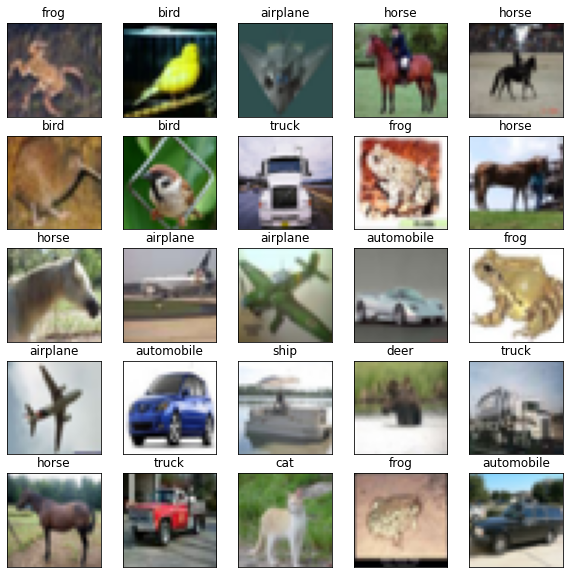

In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

cifar10_data = CIFAR10(root="./data",
                       train=False,download=True,
                       transform=transforms.ToTensor())
cifar10_classes = np.array(["airplane", "automobile", "bird", "cat", "deer",
                            "dog", "frog", "horse", "ship", "truck"])
print("データの数:", len(cifar10_data))

n_image = 25  # 表示する画像の数
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)
dataiter = iter(cifar10_loader)  # イテレータ
images, labels = dataiter.next()  # 最初のバッチを取り出す

plt.figure(figsize=(10,10))  # 画像の表示サイズ
for i in range(n_image):
    plt.subplot(5,5,i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))  # チャンネルを一番後ろに
    label = cifar10_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

plt.show()

## データ拡張
torchvision.transformsを使ってデータ拡張を行います。  
今回は、cifar-10の画像に-30〜30°の回転、および0.8〜1.2倍のリサイズを行います。  
これらの処理は、バッチを取り出す際に元の画像に対してランダムに加えられます。    


Files already downloaded and verified
データの数: 10000


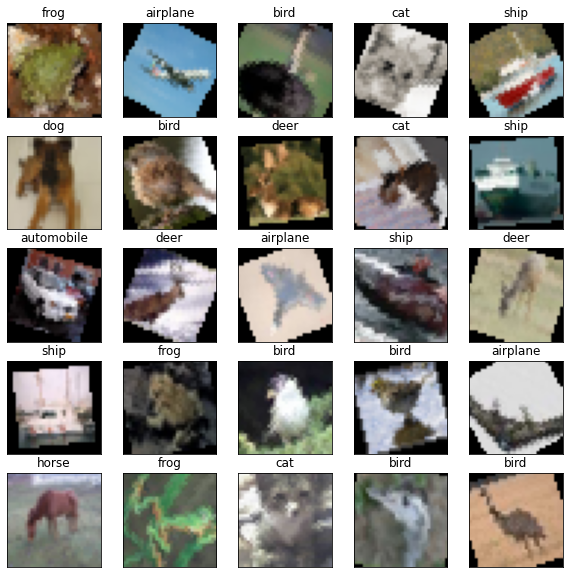

In [2]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.RandomAffine([-30, 30], scale=(0.8, 1.2)),  # 回転とリサイズ
                                transforms.ToTensor()])
cifar10_data = CIFAR10(root="./data",
                       train=False,download=True,
                       transform=transform)
cifar10_classes = np.array(["airplane", "automobile", "bird", "cat", "deer",
                            "dog", "frog", "horse", "ship", "truck"])
print("データの数:", len(cifar10_data))

n_image = 25  # 表示する画像の数
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)
dataiter = iter(cifar10_loader)  # イテレータ
images, labels = dataiter.next()  # 最初のバッチを取り出す

plt.figure(figsize=(10,10))  # 画像の表示サイズ
for i in range(n_image):
    plt.subplot(5,5,i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))  # チャンネルを一番後ろに
    label = cifar10_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

plt.show()

## データの前処理
ここからCNNを実装します。  
データ拡張として、回転とリサイズ、および左右反転を行います。  
また、学習が効率的になるように入力の平均値を0、標準偏差を1にします（標準化）。  
DataLoaderは、訓練データ、テストデータそれぞれで設定しますが、テストデータにはミニバッチ法を適用しないのでバッチサイズは元データのサンプル数にします。

In [3]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

affine = transforms.RandomAffine([-15, 15], scale=(0.8, 1.2))  # 回転とリサイズ
flip = transforms.RandomHorizontalFlip(p=0.5)  # 左右反転
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # 平均値を0、標準偏差を1に
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoaderの設定
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## モデルの構築
`nn.Module`モジュールを継承したクラスとして、モデルを構築します。  
今回は、過学習を抑制するためにドロップアウトを導入します。  

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数、フィルタサイズ)
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, ストライド）
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## 学習
モデルを訓練します。  
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行います。  
今回は、評価時にミニバッチ法は使わず、テストデータ全体を使って一度に誤差を計算します。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。


In [5]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
x_test, t_test = iter(test_loader).next()
x_test, t_test = x_test.cuda(), t_test.cuda()
for i in range(20):  # 20エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    y_test = net(x_test)
    loss_test = loss_fnc(y_test, t_test).item()
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0 Loss_Train: 1.799057403488842 Loss_Test: 1.5047701597213745
Epoch: 1 Loss_Train: 1.5542813908413549 Loss_Test: 1.404483437538147
Epoch: 2 Loss_Train: 1.4648001735167735 Loss_Test: 1.3086496591567993
Epoch: 3 Loss_Train: 1.4145157318895736 Loss_Test: 1.28035569190979
Epoch: 4 Loss_Train: 1.3721532191309478 Loss_Test: 1.2863308191299438
Epoch: 5 Loss_Train: 1.342715614592023 Loss_Test: 1.219057321548462
Epoch: 6 Loss_Train: 1.316473909351222 Loss_Test: 1.2047525644302368
Epoch: 7 Loss_Train: 1.3019705837797326 Loss_Test: 1.2063393592834473
Epoch: 8 Loss_Train: 1.2833813136953223 Loss_Test: 1.143038034439087
Epoch: 9 Loss_Train: 1.2637574277875367 Loss_Test: 1.144716739654541
Epoch: 10 Loss_Train: 1.250102816487822 Loss_Test: 1.124892234802246
Epoch: 11 Loss_Train: 1.243864127437172 Loss_Test: 1.1064014434814453
Epoch: 12 Loss_Train: 1.2362593556456554 Loss_Test: 1.1182518005371094
Epoch: 13 Loss_Train: 1.2207591371310642 Loss_Test: 1.096908450126648
Epoch: 14 Loss_Train: 1.21731

## 誤差の推移
訓練データ、テストデータで誤差の推移をグラフ表示します。  

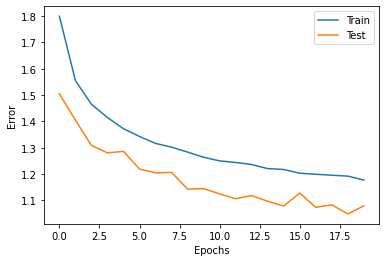

In [6]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率
モデルの性能を把握するため、テストデータ使い正解率を測定します。  

In [7]:
correct = 0
total = 0
net.eval()  # 評価モード
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU対応
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("正解率:", str(correct/total*100) + "%")

正解率: 61.63999999999999%


## 訓練済みのモデルを使った予測
訓練済みのモデルを使ってみましょう。  
画像を入力し、モデルが機能していることを確かめます。

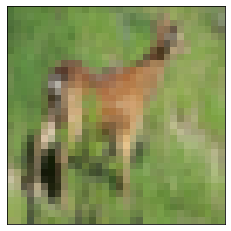

正解: deer 予測結果: deer


In [8]:
cifar10_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)
dataiter = iter(cifar10_loader)
images, labels = dataiter.next()  # サンプルを1つだけ取り出す

plt.imshow(np.transpose(images[0], (1, 2, 0)))  # チャンネルを一番後ろに
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
plt.show()

net.eval()  # 評価モード
x, t = images.cuda(), labels.cuda()  # GPU対応
y = net(x)
print("正解:", cifar10_classes[labels[0]],
      "予測結果:", cifar10_classes[y.argmax().item()])